In [1]:
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# sns.set()

import os

import warnings
warnings.filterwarnings('ignore')

In [2]:
import joblib
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.feature_selection import SelectPercentile, f_classif, f_regression, SelectFromModel, RFE
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Flatten, Dense, Input, concatenate, Embedding, Dot
from tensorflow.keras.layers import Activation, ReLU, LeakyReLU, PReLU
from tensorflow.keras.layers import BatchNormalization, Dropout, AlphaDropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import plot_model

from functools import partial

# Data load

In [4]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# Column 설정

In [5]:
target = 'target'

In [6]:
columns_useless = ['id']
# columns_useless = columns_useless + ['nom_5', 'nom_6', 'nom_7', 'nom_8', 'nom_9', 'ord_5']

In [7]:
columns_num_all = joblib.load('columns_num.pkl')
columns_cat_all = joblib.load('columns_cat.pkl')
columns_binary_num = joblib.load('columns_binary_num.pkl')
columns_binary_cat = joblib.load('columns_binary_cat.pkl')

In [8]:
try :
    columns_num_all.remove(target)
    
except :
    pass

In [9]:
try :
    columns_cat_all.remove(target)
    
except :
    pass

In [10]:
columns_num = []

for column in columns_num_all :
    
    if column not in columns_useless :
        columns_num.append(column)

In [11]:
columns_cat = []

for column in columns_cat_all :
    
    if column not in columns_useless :
        columns_cat.append(column)

In [12]:
columns_sc = []

for column in columns_num :
    
    if column not in columns_binary_num:
        columns_sc.append(column)
        
columns_sc

[]

In [13]:
columns_en = []

for column in columns_cat :
    
    if (column not in columns_binary_num) and (column not in columns_binary_cat):
        columns_en.append(column)
        
columns_en

['nom_0',
 'nom_1',
 'nom_2',
 'nom_3',
 'nom_4',
 'nom_5',
 'nom_6',
 'nom_7',
 'nom_8',
 'nom_9',
 'ord_1',
 'ord_2',
 'ord_3',
 'ord_4',
 'ord_5',
 'ord_0',
 'day',
 'month']

# Target 분리

In [14]:
# y = data[target]
# X = data.drop(target, axis=1)

In [15]:
y_train = train[target]
X_train = train.drop(target, axis=1)
X_train_og = X_train.copy()

In [16]:
X_test = test.copy()

# 전체 dataset concat

In [17]:
all_data = pd.concat([X_train, X_test])

# Data preprocessing

In [18]:
def preprocessing(data, X_train_og, columns_useless, columns_sc, columns_binary_cat, columns_en) :
    
    # useless column 제거
    data.drop(columns_useless, axis=1, inplace=True)
    
    # scaling
#     scaler = StandardScaler()
#     scaler.fit(X_train_og[columns_sc])
#     data[columns_sc] = scaler.transform(data[columns_sc])

    # binary data 처리
    column = columns_binary_cat[0]
    index_1 = data[data[column] == 'T'].index
    index_0 = data[data[column] == 'F'].index
    data.loc[index_1, column] = 1
    data.loc[index_0, column] = 0
    
    column = columns_binary_cat[1]
    index_1 = data[data[column] == 'Y'].index
    index_0 = data[data[column] == 'N'].index
    data.loc[index_1, column] = 1
    data.loc[index_0, column] = 0
    
    data[columns_binary_cat] = data[columns_binary_cat].astype('int64')
    
    # One-hot-encoding
#     data = pd.get_dummies(data, columns=columns_en)
    encoder = OneHotEncoder()   # 고윳값을 많이 가진 feature가 있는 경우는 OneHotEncoder를 사용해야 함
    data = encoder.fit_transform(data)
    
    return data

In [19]:
all_data = preprocessing(all_data, X_train_og, columns_useless, columns_sc, columns_binary_cat, columns_en)

# Train & test set 분리

In [20]:
X_train = all_data[:len(train)]
X_test = all_data[len(train):]

# Validation set 분리
- Train dataset이 너무 커서 cross validation에 너무 오랜 시간이 걸리는 경우
- OneHotEncoder를 사용하면 sparse matrix를 return하기 때문에 neural network에서 validation_split를 사용할 수 없는 경우

In [21]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=30)

In [22]:
y_train = tf.keras.utils.to_categorical(y_train, num_classes=2)   # metrics로 'AUC'를 사용하기 위해 one-hot-encoding 사용
y_val = tf.keras.utils.to_categorical(y_val, num_classes=2)

# Grid search

In [23]:
np.random.seed(30)
tf.random.set_seed(30)

In [24]:
HiddenDense = partial(Dense, activation='selu', kernel_initializer='lecun_normal')

In [25]:
model = Sequential()
model.add(HiddenDense(100, input_shape=(X_train.shape[1],)))

for layer in range(10):
    model.add(HiddenDense(100))
    
model.add(Dense(2, activation='softmax'))

In [26]:
def build_model(n_layers=5, n_units=100, learning_rate=0.001, input_shape=(X_train.shape[1],)):
    model = keras.models.Sequential()
    model.add(HiddenDense(n_units, input_shape=(X_train.shape[1],)))
    
    for layer in range(n_layers):
        model.add(HiddenDense(n_units))
        
    model.add(Dense(2, activation='softmax'))
    
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    # scikit-learn wrapper 사용을 위해 분류는 metrics로 accuracy를 사용해야만 함
    
    return model

In [27]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

In [28]:
model = keras.wrappers.scikit_learn.KerasClassifier(build_model)

In [29]:
param_grid = {
    'n_layers' : [3, 10, 20],
    'n_units': [10, 50, 100],
}

In [30]:
grid = GridSearchCV(model, param_grid, cv=3, return_train_score=True)

In [31]:
grid.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val), callbacks=early_stopping_cb, verbose=0)

4688/4688 [==============================] - 9s 2ms/step - loss: 0.4396 - accuracy: 0.7980


GridSearchCV(cv=3,
             estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x00000296EC20A7B8>,
             param_grid={'n_layers': [3, 10, 20], 'n_units': [10, 50, 100]},
             return_train_score=True)

- 너무 오래 걸림

In [32]:
results = pd.DataFrame(grid.cv_results_)
results = results[['params', 'mean_test_score', 'mean_train_score', 'mean_fit_time', 'mean_score_time']]
display(results)

,params,mean_test_score,mean_train_score,mean_fit_time,mean_score_time
0,"{'n_layers': 3, 'n_units': 10}",0.757969,0.782624,215.560837,8.241793
1,"{'n_layers': 3, 'n_units': 50}",0.756164,0.783258,528.615562,10.128400
2,"{'n_layers': 3, 'n_units': 100}",0.755289,0.786869,893.335330,9.991481
3,"{'n_layers': 10, 'n_units': 10}",0.757462,0.782900,281.300412,9.691030
4,"{'n_layers': 10, 'n_units': 50}",0.754836,0.783351,634.976807,10.939618
5,"{'n_layers': 10, 'n_units': 100}",0.752942,0.789567,1171.651166,13.892306
6,"{'n_layers': 20, 'n_units': 10}",0.755067,0.787424,368.933678,11.045462
7,"{'n_layers': 20, 'n_units': 50}",0.752658,0.785251,715.336238,9.960598
8,"{'n_layers': 20, 'n_units': 100}",0.751551,0.797964,660.997908,4.714022


Text(87.0, 0.5, 'n_units')

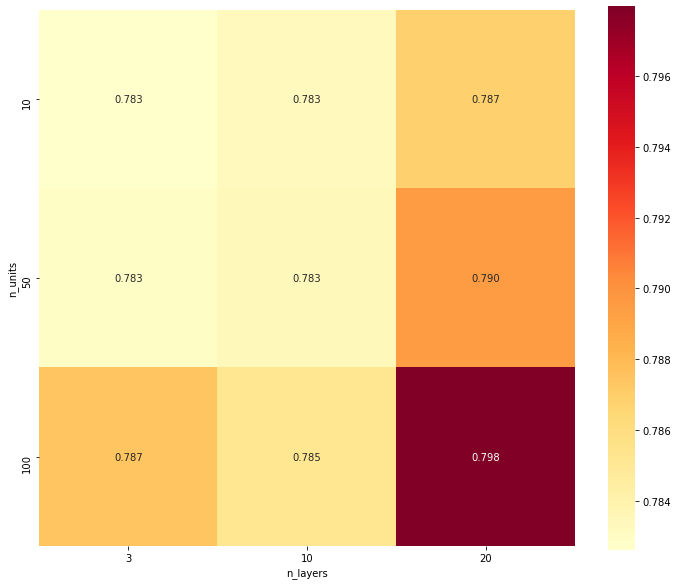

In [33]:
score = np.array(results.mean_train_score).reshape(len(list(param_grid.values())[1]), len(list(param_grid.values())[0]))

fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(score, xticklabels=list(param_grid.values())[0], yticklabels=list(param_grid.values())[1], 
            annot=True, fmt='.3f', square=True, cbar=True, cmap='YlOrRd')

plt.xlabel(list(param_grid.keys())[0])
plt.ylabel(list(param_grid.keys())[1])

Text(87.0, 0.5, 'n_units')

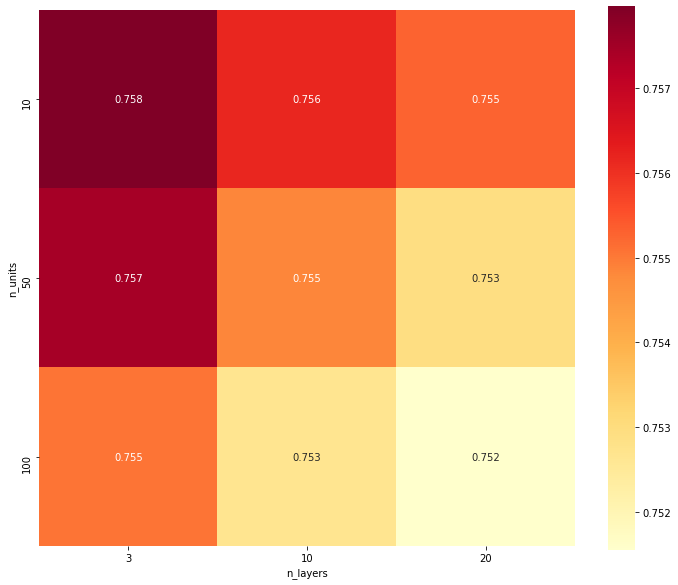

In [34]:
score = np.array(results.mean_test_score).reshape(len(list(param_grid.values())[1]), len(list(param_grid.values())[0]))

fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(score, xticklabels=list(param_grid.values())[0], yticklabels=list(param_grid.values())[1], 
            annot=True, fmt='.3f', square=True, cbar=True, cmap='YlOrRd')

plt.xlabel(list(param_grid.keys())[0])
plt.ylabel(list(param_grid.keys())[1])

In [35]:
print('best hyperpameter : \n{}' .format(grid.best_params_), '\n')
print("best score : {:.3f}".format(grid.best_score_))

best hyperpameter : 
{'n_layers': 3, 'n_units': 10} 

best score : 0.758
